# Build a Pipeline with Ensemble Methods 

In [37]:
#workflow and statistics
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

#for showing missing values
import missingno as msno

#visualisation
import seaborn as sns

#natural language processing toolkit
import nltk
import string
from nltk.corpus import stopwords  # removes useless words
from nltk.stem.lancaster import LancasterStemmer  #converts the words to base form; aggressive
from nltk.stem import porter
from nltk.stem.util import suffix_replace, prefix_replace
from nltk.stem.api import StemmerI
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

#accessing google cloud storage
#from google.cloud import storage
#from io import BytesIO
#client = storage.Client()
#bucket = "bilderkennung_nf_2020"

#import classification models
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



#build pipeline
import re
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

#evaluation metrics
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from datetime import datetime


# save model
import pickle


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\drena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv('data/jigsaw-toxic-comment-train.csv')

In [3]:
train.shape

(223549, 8)

In [4]:
data_ = {'toxic':[11.4], 'non-toxic':[88.9]}

In [5]:
rel_dist = pd.DataFrame.from_dict(data_)
rel_dist.transpose()

,0
toxic,11.4
non-toxic,88.9


<Figure size 720x432 with 0 Axes>

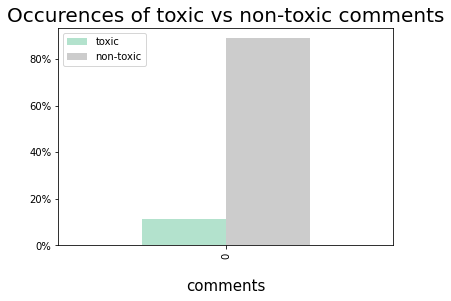

In [6]:
import matplotlib.ticker as mtick

plt.figure(1,figsize=(10,6))
ax = rel_dist.plot(kind='bar', colormap='Pastel2')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Occurences of toxic vs non-toxic comments",fontsize=20)
#plt.ylabel('number of Occurrences', fontsize=15,labelpad=20)
plt.xlabel('comments', fontsize=15,labelpad=20)
plt.show()

**Clean Data**

In [7]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
train['comment_text'] = train['comment_text'].apply(remove_punctuation)

In [8]:
sw=stopwords.words('english')
def removesw(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)
train['comment_text'] = train['comment_text'].apply(removesw)

In [9]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 
train['comment_text'] = train['comment_text'].apply(stemming)

**Train Test Split**

In [11]:
X = train[['comment_text']]
Y = train['toxic']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

**Resample Imbalanced Data**

In [12]:
from sklearn.utils import resample


# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_toxic = X[X.toxic==0]
toxic = X[X.toxic==1]

In [ ]:
## upsample minority
#toxic_upsampled = resample(toxic,
#                          replace=True, # sample with replacement
#                          n_samples=len(not_toxic), # match number in majority class
#                          random_state=27) # reproducible results
#
## combine majority and upsampled minority
#upsampled = pd.concat([not_toxic, toxic_upsampled])
#

In [13]:
# check new class counts
#upsampled.toxic.value_counts()

In [14]:
#y_train = upsampled.toxic
#X_train = upsampled.drop('toxic', axis=1)

In [15]:
#y_train

In [16]:
#X_train

In [17]:
# downsample majority
not_toxic_downsampled = resample(not_toxic,
                                replace = False, # sample without replacement
                                n_samples = len(toxic), # match minority n
                                random_state = 27) # reproducible results

In [18]:
# combine minority and downsampled majority
downsampled = pd.concat([not_toxic_downsampled, toxic])

In [19]:
# checking counts
downsampled.toxic.value_counts()

1    16081
0    16081
Name: toxic, dtype: int64

In [24]:
y_train = downsampled.toxic
X_train = downsampled.drop('toxic', axis=1)

**Preprocess Data**

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]
    
#class NumberSelector(BaseEstimator, TransformerMixin):
#    def __init__(self, field):
#        self.field = field
#    def fit(self, X, y=None):
#        return self
#    def transform(self, X):
#        return X[[self.field]]

In [26]:
import nltk

def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

After vectorizing the text, if we use the XGBoost classifier we need to add the TruncatedSVD transformer to the pipeline. Its role is to perform linear dimensionality reduction by means of truncated singular value decomposition (SVD). It works on tf-idf matrices generated by sklearn doing what’s called latent semantic analysis (LSA).

# Pipeline

The reason we use a FeatureUnion is to allow us to combine different Pipelines that run on different features of the training data.

In [27]:
models = [
    XGBClassifier, AdaBoostClassifier, RandomForestClassifier
]
for model in models:
    print(str(model))
    pipe = Pipeline([
        (
            'features',
            FeatureUnion([(
                'comment_text',
                Pipeline([
                    ('colext', TextSelector('comment_text')),
                    ('tfidf',
                     TfidfVectorizer(tokenizer=Tokenizer,
                                     min_df=.0025,
                                     max_df=0.25,
                                     ngram_range=(1, 3))),
                    ('svd', TruncatedSVD(algorithm='randomized',
                                         n_components=300)),
                ]))])),
        ('clf', model()),
    ])
    pipe_trained = pipe.fit(X_train, y_train)
    preds = cross_val_predict(pipe, X_train, y_train, cv=5)
    
    # confusion matrix and classification report
    results = confusion_matrix(y_train, preds)
    print('Confusion Matrix :')
    print((results))
    print('Accuracy Score :', accuracy_score(y_train, preds))
    print('Report : ')
    print(classification_report(y_train, preds))

pickle.dump(pipe_trained, open('saved_models/pipe_trained.pkl', 'wb'))    

<class 'xgboost.sklearn.XGBClassifier'>
Confusion Matrix :
[[14334  1747]
 [ 2659 13422]]
Accuracy Score : 0.8630060319631864
Report : 
              precision    recall  f1-score   support

           0       0.84      0.89      0.87     16081
           1       0.88      0.83      0.86     16081

    accuracy                           0.86     32162
   macro avg       0.86      0.86      0.86     32162
weighted avg       0.86      0.86      0.86     32162

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
Confusion Matrix :
[[14202  1879]
 [ 3423 12658]]
Accuracy Score : 0.8351470679684099
Report : 
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     16081
           1       0.87      0.79      0.83     16081

    accuracy                           0.84     32162
   macro avg       0.84      0.84      0.83     32162
weighted avg       0.84      0.84      0.83     32162

<class 'sklearn.ensemble._forest.RandomForestClassi

# RandomSearch and GridSearch

In [28]:
#timer frunction


def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [29]:
xgb_pipe = Pipeline([
        (
            'features',
            FeatureUnion([(
                'comment_text',
                Pipeline([
                    ('colext', TextSelector('comment_text')),
                    ('tfidf',
                     TfidfVectorizer(tokenizer=Tokenizer,
                                     min_df=.0025,
                                     max_df=0.25,
                                     ngram_range=(1, 3))),
                    ('svd', TruncatedSVD(algorithm='randomized',
                                         n_components=300)),
                ]))])),
        ('classifier', XGBClassifier())])

In [30]:
parameters_xgb = {
    'classifier__max_depth': [2,3],
    'classifier__n_estimators': [100,250,500,750,1000],
    'classifier__learning_rate': [0.1, 0.5, 1, 0.01],
}

In [40]:
# RandomizedSearch CV
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_pipe, 
                                   param_distributions=parameters_xgb, 
                                   n_iter=param_comb, 
                                   scoring='recall', 
                                   n_jobs=-1, 
                                   cv=10, 
                                   verbose=3, 
                                   random_state=1001 )

In [41]:
#grid_search_xgb = GridSearchCV(
#    estimator=xgb_pipe,
#    param_grid=parameters_xgb,
#    n_jobs = -1,
#    cv = 10,
#    verbose=5,
#    scoring='recall'
#)

In [42]:
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
RandomSearchXGB = random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 63.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 123.0min finished



 Time taken: 2 hours 5 minutes and 2.69 seconds.


In [43]:
#save model
pickle.dump(RandomSearchXGB, open('saved_models/xgb_best_model.pkl', 'wb'))


In [44]:
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

{'mean_fit_time': array([1137.40399354,  191.0494348 ,  419.54470296,  401.72799459,
        696.14670858]), 'std_fit_time': array([ 35.63562691,   2.53228169,  20.25144015,   3.96922907,
       103.93875383]), 'mean_score_time': array([4.46107121, 4.41299939, 4.3659256 , 4.36163709, 4.03191867]), 'std_score_time': array([0.17355048, 0.20725293, 0.17918415, 0.1662416 , 0.76126753]), 'param_classifier__n_estimators': masked_array(data=[750, 100, 250, 250, 750],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_classifier__max_depth': masked_array(data=[3, 3, 3, 3, 2],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_classifier__learning_rate': masked_array(data=[0.01, 0.5, 0.5, 1, 0.1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'classifier__n_estimators': 750, 'classifier__max_depth': 3, 'c

In [ ]:
y_test_predicted_xgb = RandomSearchXGB.predict(X_test)

**GridSearchCV**

In [ ]:
#print("Best parameters:\n{}".format(grid_search_xgb.best_params_))

In [ ]:
#best_model_rf = grid_search_xgb.best_estimator_['classifier']

In [ ]:
#y_test_predicted_xgb = best_model_rf.predict(X_test)

In [ ]:
#results = confusion_matrix(y_test, y_test_predicted_xgb)
#print('Confusion Matrix :')
#print((results))
#print('Accuracy Score :', accuracy_score(y_test, y_test_predicted_xgb))
#print('Report : ')
#print(classification_report(y_test, y_test_predicted_xgb))

In [ ]:
abc_pipe = Pipeline([
        (
            'features',
            FeatureUnion([(
                'comment_text',
                Pipeline([
                    ('colext', TextSelector('comment_text')),
                    ('tfidf',
                     TfidfVectorizer(tokenizer=Tokenizer,
                                     min_df=.0025,
                                     max_df=0.25,
                                     ngram_range=(1, 3))),
                    ('svd', TruncatedSVD(algorithm='randomized',
                                         n_components=300)),
                ]))])),
        ('classifier', AdaBoostClassifier())])

In [ ]:
param_abc = {dtc__criterion : ["gini", "entropy"],
              dtc__splitter :   ["best", "random"],
              abc__n_estimators: [none, 1, 2]

In [ ]:
grid_search_abc = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=parameters_abc,
    n_jobs = -1,
    cv = 10,
    verbose=5,
    scoring='recall'
)

**Confusion Matrix**

In [ ]:
#confusion matrix
    cm = skl_m.confusion_matrix(y, y_predicted)
    cm = cm.astype('float') / cm.sum(axis=1) [:, np.newaxis] 
    
    # view with a heatmap
    plt.figure()
    sns.heatmap(cm, annot=True, annot_kws={"size":30},
                cmap='viridis', square=True, fmt='.0%')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));
    name=[x for x in globals() if globals()[x] is X][0]
    plt.savefig('figures/'+model.__class__.__name__+'_'+name+'.png')